In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [13]:
# Import data

# Products of interest
products = pd.read_csv(r'C:\Users\Joel\Dropbox\PROGRAMMING\Personal Projects\AB Testing Project\Given Files\products_of_interest.csv', header = None)
products.rename(columns = {0: 'IDs'}, inplace = True)

# Store Attributes
attributes = pd.read_csv(r'C:\Users\Joel\Dropbox\PROGRAMMING\Personal Projects\AB Testing Project\Given Files\store_attributes.csv', index_col = 0, header = 0)

# # Transaction data
transactions = pd.read_csv(r'C:\Users\Joel\Dropbox\PROGRAMMING\Personal Projects\AB Testing Project\Given Files\transactions.csv', header = 0, index_col = 0)

In [11]:
# Check products
products.head()

,IDs
0,30898
1,30710
2,30844
3,30900
4,30981


In [12]:
# Check Attributes
attributes.head()

,store_id,attribute_id,attribute_type,attribute_int_val,attribute_str_val,attribute_float_val
0,631,8,float,NaN,NaN,9447217.69
1,501,8,float,NaN,NaN,8807968.29
2,486,8,float,NaN,NaN,4038617.13
3,392,8,float,NaN,NaN,12222048.62
4,561,8,float,NaN,NaN,4298550.49


In [14]:
# Check transactions
transactions.head()

,date_week,store_id,product_id,currency_code,revenue
0,2016-07-10 00:00:00.000000,526,31107,USD,3.32
1,2016-07-10 00:00:00.000000,526,30772,USD,1.99
2,2016-07-10 00:00:00.000000,526,30887,USD,5.32
3,2016-07-10 00:00:00.000000,526,31133,USD,6.98
4,2016-07-10 00:00:00.000000,526,31118,USD,1.99


In [15]:
# Check transaction data types
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1224305 entries, 0 to 1224304
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   date_week      1224305 non-null  object 
 1   store_id       1224305 non-null  int64  
 2   product_id     1224305 non-null  int64  
 3   currency_code  1224305 non-null  object 
 4   revenue        1224305 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 56.0+ MB


- Lets make a DataFrame which only revolves around the products of interest.
- This is so we can run the test without interference from other products. This variable can be changed should the test be repeated.

In [16]:
relevant_df = transactions[transactions['product_id'].isin(products['IDs'])]
relevant_df

,date_week,store_id,product_id,currency_code,revenue
0,2016-07-10 00:00:00.000000,526,31107,USD,3.32
1,2016-07-10 00:00:00.000000,526,30772,USD,1.99
2,2016-07-10 00:00:00.000000,526,30887,USD,5.32
3,2016-07-10 00:00:00.000000,526,31133,USD,6.98
4,2016-07-10 00:00:00.000000,526,31118,USD,1.99
...,...,...,...,...,...
1224299,2017-02-12 00:00:00.000000,610,30720,USD,2.78
1224300,2017-02-12 00:00:00.000000,610,30940,USD,7.96
1224302,2017-02-12 00:00:00.000000,610,30749,USD,2.78
1224303,2017-02-12 00:00:00.000000,610,30805,USD,1.99


In [17]:
# Convert date_week column to datetime
relevant_df['date_week'] = pd.to_datetime(relevant_df['date_week'])
relevant_df

C:\Users\Joel\AppData\Local\Temp\ipykernel_7380\149319398.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_df['date_week'] = pd.to_datetime(relevant_df['date_week'])


,date_week,store_id,product_id,currency_code,revenue
0,2016-07-10,526,31107,USD,3.32
1,2016-07-10,526,30772,USD,1.99
2,2016-07-10,526,30887,USD,5.32
3,2016-07-10,526,31133,USD,6.98
4,2016-07-10,526,31118,USD,1.99
...,...,...,...,...,...
1224299,2017-02-12,610,30720,USD,2.78
1224300,2017-02-12,610,30940,USD,7.96
1224302,2017-02-12,610,30749,USD,2.78
1224303,2017-02-12,610,30805,USD,1.99


In [18]:
# Check
relevant_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1118551 entries, 0 to 1224304
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   date_week      1118551 non-null  datetime64[ns]
 1   store_id       1118551 non-null  int64         
 2   product_id     1118551 non-null  int64         
 3   currency_code  1118551 non-null  object        
 4   revenue        1118551 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 51.2+ MB


# Isolate the Pre-Trial Data
- The pre-trial period goes from 17-07-2016 to 15-10-2016.

In [19]:
# Isolate pre-trial data
mask = (relevant_df['date_week'] >'2016-07-16') & (relevant_df['date_week'] < '2016-10-16')
pre_trial = relevant_df.loc[mask]
pre_trial

,date_week,store_id,product_id,currency_code,revenue
19439,2016-07-17,526,30936,USD,1.66
19440,2016-07-17,526,30874,USD,20.64
19441,2016-07-17,526,31175,USD,1.67
19442,2016-07-17,526,30690,USD,8.97
19443,2016-07-17,526,31174,USD,14.29
...,...,...,...,...,...
535837,2016-10-09,427,31098,USD,5.28
535838,2016-10-09,427,30902,USD,3.98
535839,2016-10-09,427,31036,USD,3.61
535840,2016-10-09,427,31022,USD,29.85


# Group by Store and Revenue
- Since we have already isolated transactions based off relevant products, we now want to group the stores by some metric. In this case, we will group by revenue by week. This means that the resulting dataframe is a collection of all weekly revenue resulting from the products of interest. In this way, we can create dataframe of unique vectors pertaining to each stores performance.

In [20]:
store_rev = pre_trial.groupby(['store_id', 'date_week'])['revenue'].sum()
store_rev = pd.DataFrame(store_rev)

store_rev.reset_index(level = 1, inplace = True)
store_rev

,date_week,revenue
store_id,,
339,2016-07-17,1216.29
339,2016-07-24,971.42
339,2016-07-31,988.36
339,2016-08-07,1056.12
339,2016-08-14,1219.31
...,...,...
675,2016-09-11,1535.77
675,2016-09-18,1452.93
675,2016-09-25,1543.24


In [21]:
# Allocate date_week as week numbers during pre-trial period

# Create test df
test = store_rev

# Get unique dates for weeks
dates = test['date_week'].value_counts().sort_index().index

# Week Number allocation
week_num = list(range(1,14))

# Empty mapping variable
mapping = {}

# Fill mapping
for date in dates:
    for week in week_num:
        mapping[date] = week
        week_num.remove(week)
        break

test['date_week'] = test['date_week'].map(mapping)
test


,date_week,revenue
store_id,,
339,1,1216.29
339,2,971.42
339,3,988.36
339,4,1056.12
339,5,1219.31
...,...,...
675,9,1535.77
675,10,1452.93
675,11,1543.24


In [22]:
store_rev['week_num'] = np.array(test['date_week'])
store_rev

,date_week,revenue,week_num
store_id,,,
339,1,1216.29,1
339,2,971.42,2
339,3,988.36,3
339,4,1056.12,4
339,5,1219.31,5
...,...,...,...
675,9,1535.77,9
675,10,1452.93,10
675,11,1543.24,11


In [23]:
# Drop extra column
store_rev.drop(columns = ['date_week'], inplace = True)
store_rev

,revenue,week_num
store_id,,
339,1216.29,1
339,971.42,2
339,988.36,3
339,1056.12,4
339,1219.31,5
...,...,...
675,1535.77,9
675,1452.93,10
675,1543.24,11


# Determining the amount of clusters

- Under the assumption that there are multiple sizes of stores, we want to find out how many categories would be optimal. For each cluster or 'group', we can then choose a trial and control pair from those clusters. This cluster number must be determined so we can label all stores by their group/cluster. 

- Once each cluster has been assigned, we can choose the trial and control pairs.

C:\Users\Joel\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=15.
  warnings.warn(


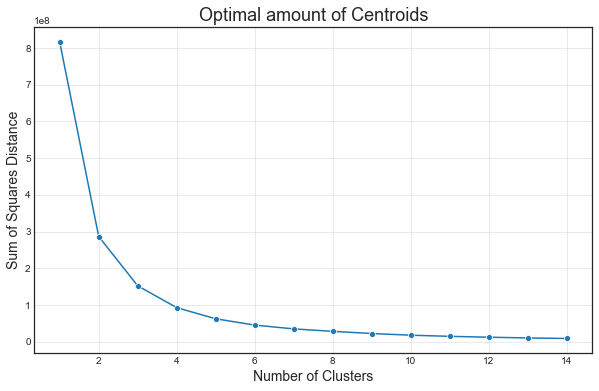

In [25]:
# Elbow method test
X = store_rev[['week_num','revenue']]

clusters = range(1,15)
intertia = []

# initialize model
for i in clusters:
    kmod = KMeans(n_clusters = i)
    kmod.fit(X)
    intertia.append(kmod.inertia_)
    
# PLOT
# Styling
plt.figure(figsize = (10,6))
plt.style.use('seaborn-white')

# Plot
sns.lineplot(x = clusters, y = intertia, palette = 'mako', marker = 'o')

# Labels
plt.xlabel('Number of Clusters', fontsize = 14)
plt.ylabel('Sum of Squares Distance', fontsize = 14)
plt.title('Optimal amount of Centroids', fontsize = 18)

# Grid
plt.grid(alpha = 0.5)

# Show
plt.show()

- Using the elbow method, we can determine the optimal amount of centroids to be 2 to 3 clusters. To be safe, we will choose 3 clusters.

- This means we can assume there are 3 groups:
    Small, 
    Medium, 
    Large 
    
    OR
    
    Low selling stores, 
    Medium selling stores, 
    High Selling stores.

In [27]:
# Assign labels
kmodel = KMeans(n_clusters=3)
kmodel.fit(X)
labels = kmodel.labels_
store_rev['labels'] = labels
store_rev.iloc[:30,:]

,revenue,week_num,labels
store_id,,,
339,1216.29,1,1
339,971.42,2,1
339,988.36,3,1
339,1056.12,4,1
339,1219.31,5,1
339,936.02,6,1
339,1106.60,7,1
339,1175.39,8,1
339,1205.55,9,1


In [31]:
store_rev

,store_id,revenue,week_num,labels
0,339,1216.29,1,1
1,339,971.42,2,1
2,339,988.36,3,1
3,339,1056.12,4,1
4,339,1219.31,5,1
...,...,...,...,...
3615,675,1535.77,9,0
3616,675,1452.93,10,0
3617,675,1543.24,11,0
3618,675,1541.17,12,0


In [39]:
# Group by aggregating modal value of cluster
store_rev_labels = []
store_rev_final = store_rev
# store_rev_final.reset_index(inplace = True)
store_rev_labels = store_rev_final.groupby(['store_id'])['labels'].agg(pd.Series.mode)
store_rev_labels = pd.DataFrame(store_rev_labels)
# store_rev_labels
store_rev_labels

,labels
store_id,
339,1
340,1
341,0
342,0
343,0
...,...
670,1
672,1
673,0


In [42]:
store_rev2 = store_rev.iloc[:, 1:]
store_rev2

,store_id,revenue,week_num,labels
0,339,1216.29,1,1
1,339,971.42,2,1
2,339,988.36,3,1
3,339,1056.12,4,1
4,339,1219.31,5,1
...,...,...,...,...
3615,675,1535.77,9,0
3616,675,1452.93,10,0
3617,675,1543.24,11,0
3618,675,1541.17,12,0


In [43]:
# Export dataframes for next notebook
store_rev_labels.to_csv('Store_Clusters.csv')
store_rev2.to_csv('store_labels_with_stats.csv')